We start by loading the data and defining a time column. Time (in seconds) at the $n^{\text{th}}$ row is defined as $$2n + 5.5 \cdot 3600 \cdot \lfloor \frac{n-1}{900} \rfloor $$

In [1]:
import pandas as pd
import numpy as np

csv_file_path = '../Lifespan/control/speeds_and_coordinates_20241016_36_updated.csv'
data = pd.read_(csv_file_path)

def calculate_mapped_values(data):
    """
    Adds a new column to the DataFrame that maps the nth row to the formula:
    2 * n + floor((n - 1) / 900) * 5.5 * 3600.

    Args:
        data (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: Updated DataFrame with the new 'Mapped Value' column.
    """
    # Calculate row indices starting from 1
    n = data.index + 1  # Row index (n), starting from 1
    # Apply the formula (see iPad)
    data['Time elapsed (in sec)'] = 2 * n + np.floor((n - 1) / 900) * 5.5 * 3600
    data['Time elapsed (in hours)'] = data['Time elapsed (in sec)']/3600
    return data


data['group'] = data.index.map(lambda x : np.floor((x)/900) )
data = calculate_mapped_values(data)
print(data.iloc[898:904])

     Frame     Speed           X           Y  Changed Pixels  group  \
898    899  0.594128  435.915344  484.682540              10    0.0   
899    900  2.396308  435.928934  484.385787              30    0.0   
900    901  0.286391  436.597765  485.379888               4    1.0   
901    902  0.203891  436.731844  485.329609               4    1.0   
902    903  0.232862  436.715084  485.430168               5    1.0   
903    904  0.496733  436.661111  485.533333              13    1.0   

     Time elapsed (in sec)  Time elapsed (in hours)  
898                 1798.0                 0.499444  
899                 1800.0                 0.500000  
900                21602.0                 6.000556  
901                21604.0                 6.001111  
902                21606.0                 6.001667  
903                21608.0                 6.002222  


We calculate our own speed column based on the formula $$\text{Speed}_t = \frac{\sqrt{(X_t - X_{t-1})^2+(Y_t - Y_{t-1})^2}}{2}$$
which is shifted and 4 times less than the given speed column.

In [2]:
# Calculate differences in X, Y, and time
data_dx = data['X'].diff()
data_dy = data['Y'].diff()
delta_time = data['Time elapsed (in sec)'].diff()

distance = np.sqrt(data_dx**2 + data_dy**2)
data['dist'] = distance
# Calculate speed as distance divided by time
data['EucSpeed'] = distance / delta_time

In [3]:
condition = (data.index) % 900 == 0
data['Changed Pixels'] = data['Changed Pixels'].shift(1)
data.loc[condition, ['EucSpeed', 'Changed Pixels']] = None
data.iloc[897:902]

,Frame,Speed,X,Y,Changed Pixels,group,Time elapsed (in sec),Time elapsed (in hours),dist,EucSpeed
897,898,0.854353,435.934426,485.109290,4.0,0.0,1796.0,0.498889,0.100206,0.050103
898,899,0.594128,435.915344,484.682540,14.0,0.0,1798.0,0.499444,0.427176,0.213588
899,900,2.396308,435.928934,484.385787,10.0,0.0,1800.0,0.500000,0.297064,0.148532
900,901,0.286391,436.597765,485.379888,NaN,1.0,21602.0,6.000556,1.198154,NaN
901,902,0.203891,436.731844,485.329609,4.0,1.0,21604.0,6.001111,0.143196,0.071598


A worm sometimes has a behavior where its center of mass is nearly stationary but its head and tail move (see Youtube link). To find when the worm dies, we look at when is there a significant drop in the changed pixels column, which will tell us that the whole body of the worm is stationary. 

Basic Statistics:
              Frame         Speed             X             Y  Changed Pixels  \
count  75593.000000  75593.000000  75159.000000  75159.000000    75509.000000   
mean    5400.000000      1.642650    506.423024    421.537122       30.117933   
std     3117.423385     11.237615     83.257890    141.311551       48.385512   
min        1.000000      0.000000    224.780000     79.398305        0.000000   
25%     2700.000000      0.143000    455.231501    312.633045        4.000000   
50%     5400.000000      0.484953    523.060694    411.720574       16.000000   
75%     8100.000000      1.415261    566.032160    519.119048       39.000000   
max    10799.000000    637.292545    749.000000    676.951945     2186.000000   

              group  Time elapsed (in sec)  Time elapsed (in hours)  \
count  75593.000000           7.559300e+04             75593.000000   
mean      41.496157           8.972179e+05               249.227197   
std       24.244987           5.236918e

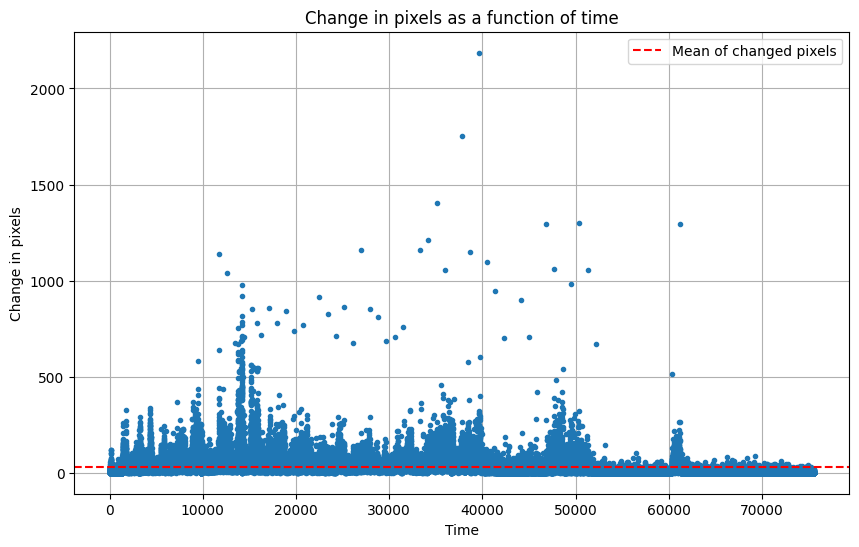

In [4]:
import matplotlib.pyplot as plt

def analyze_and_plot_worm(data):
    """
    Reads a CSV file containing worm trajectory data, performs basic data analysis,
    and plots (X, Y) as a function of time, connecting points in the order listed.
    
    Args:
        csv_file (str): Path to the CSV file.
    """
    
    #data = data.iloc[2000:4000]
    # Quick Data Analysis
    print("Basic Statistics:")
    print(data.describe())
    print("\nMissing Values:")
    print(data.isnull().sum())
    
    #IMPORTANT
    time = range(len(data))
    
    # Plot (X, Y) trajectory
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Changed Pixels'], marker='.', linestyle='')
    plt.title("Change in pixels as a function of time")
    plt.xlabel("Time")
    plt.ylabel("Change in pixels")
    plt.axhline(y=data['Changed Pixels'].mean(), color='red', linestyle='--', label='Mean of changed pixels')
    plt.grid(True)
    plt.legend()
    plt.show()

analyze_and_plot_worm(data)


In [5]:
def find_death_row(data, change_col='Changed Pixels', threshold=5, window=10, persistence=0.9):
    """
    Find the first row where the worm is considered "dead."
    
    Args:
        data (pd.DataFrame): The worm's trajectory data.
        change_col (str): Column indicating changes in pixels.
        threshold (int): Threshold below which the worm is considered inactive.
        window (int): Number of subsequent rows to check for inactivity.
        persistence (float): Fraction of rows in the window that must satisfy the condition.
    
    Returns:
        int: Index of the death row or -1 if no such row is found.
    """
    for i in range(len(data) - window):
        # Check if the current row satisfies the condition
        if data.loc[i, change_col] < threshold:
            # Check the persistence condition in the window
            subsequent = data[change_col].iloc[i:i+window]
            if (subsequent < threshold).sum() >= persistence * window:
                return i
    return -1  # Return -1 if no death row is found

death_row = find_death_row(data, change_col='Changed Pixels', threshold=5, window=500, persistence=0.9)
print(f"Death row: {death_row}")
final_age = data['Time elapsed (in hours)'].iloc[death_row]
print(f"The worm lived: {final_age/24} days.")

Death row: 59408
The worm lived: 16.500208333333333 days.


We now handle NaN values before going further. They include rows where speed is undefined (at resets of recording) or blocks of rows with missing data where the worm moves out of the field of view or if there is an error in tracking. If the block is not very big, we will interpolate the positions of the worm assuming it will have an uniform speed. We will delete the rows otherwise. Additionally, if a recording cut happens in the middle of a block a missing data, the block will be deleted no matter its length.

Basic Statistics:
              Frame         Speed             X             Y  Changed Pixels  \
count  75593.000000  75593.000000  75159.000000  75159.000000    75509.000000   
mean    5400.000000      1.642650    506.423024    421.537122       30.117933   
std     3117.423385     11.237615     83.257890    141.311551       48.385512   
min        1.000000      0.000000    224.780000     79.398305        0.000000   
25%     2700.000000      0.143000    455.231501    312.633045        4.000000   
50%     5400.000000      0.484953    523.060694    411.720574       16.000000   
75%     8100.000000      1.415261    566.032160    519.119048       39.000000   
max    10799.000000    637.292545    749.000000    676.951945     2186.000000   

              group  Time elapsed (in sec)  Time elapsed (in hours)  \
count  75593.000000           7.559300e+04             75593.000000   
mean      41.496157           8.972179e+05               249.227197   
std       24.244987           5.236918e

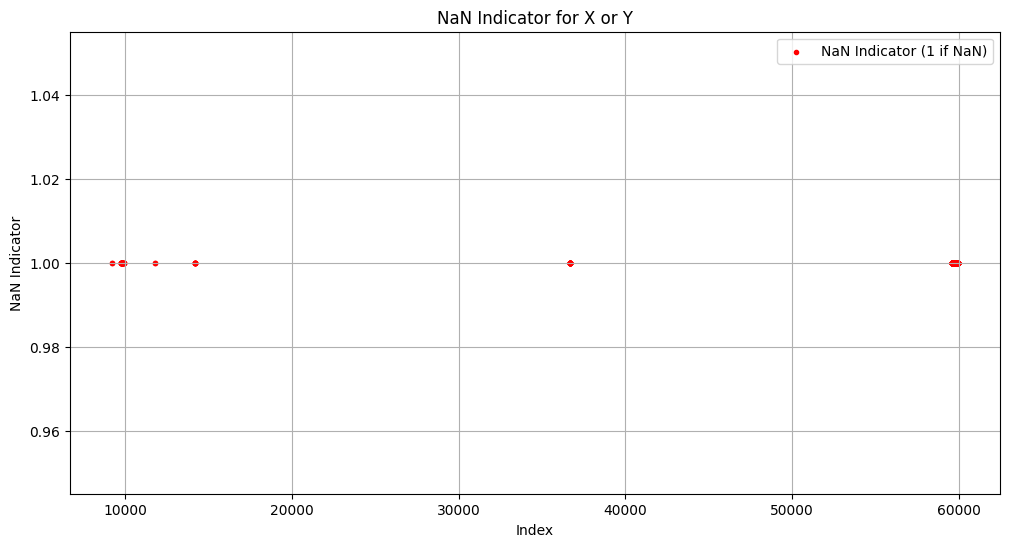

   gap_id  Start Row  End Row  Length  Contains Cut
0       2       9231     9232       2         False
1       4       9768     9798      31         False
2       6       9895     9899       5         False
3       8      11761    11762       2         False
4      10      14195    14202       8         False
5      12      36668    36684      17         False
6      14      59569    59937     369         False


In [6]:
print("Basic Statistics:")
print(data.describe())
print("\nMissing Values:")
print(data.isnull().sum())

#Handling NaNs
columns=['X','Y']
nan_rows = data[data[columns].isnull().any(axis=1)]

def plot_nan_indicator(data, columns=['X', 'Y']):
    """
    Plots an indicator where 1 represents NaN values in the specified columns.
    Nothing is plotted for rows without NaN.

    Args:
        data (pd.DataFrame): The input DataFrame.
        columns (list): List of column names to check for NaN values.
    """
    # Create an indicator: 1 if any specified column has NaN, otherwise NaN (no plot for valid values)
    nan_indicator = data[columns].isnull().any(axis=1).astype(int)
    nan_indicator = nan_indicator.replace(0, None)  # Replace 0 with None to exclude from plot

    # Plot the indicator
    plt.figure(figsize=(12, 6))
    plt.scatter(data.index, nan_indicator, label='NaN Indicator (1 if NaN)', color='red', marker='.')
    plt.xlabel('Index')
    plt.ylabel('NaN Indicator')
    plt.title('NaN Indicator for X or Y')
    plt.grid(True)
    plt.legend()
    plt.show()


# Plot NaN indicator for Speed and Acceleration
plot_nan_indicator(data, columns=['X', 'Y'])

data['is_nan'] = data[columns].isnull().any(axis=1)

# Assign unique IDs to consecutive NaN groups
data['gap_id'] = (data['is_nan'] != data['is_nan'].shift()).cumsum() * data['is_nan']

# Group by gap_id to calculate the size of each gap and check for recording cuts
gaps = (
    data[data['is_nan']]
    .groupby('gap_id')
    .apply(lambda group: pd.Series({
        'Start Row': group.index.min(),
        'End Row': group.index.max(),
        'Length': group.index.max() - group.index.min() + 1,
        'Contains Cut': any((group.index) % 900 == 0)  # Check for recording cuts
    }))
    .reset_index()
)
print(gaps)

#gap_length_threshold = 40
#columns=['X', 'Y']
# Process each gap
#for _, gap in gaps.iterrows():
#    gap_id = gap['gap_id']
#    start_row, end_row, length, contains_cut = gap['Start Row'], gap['End Row'], gap['Length'], gap['Contains Cut']

#    if contains_cut or length >= gap_length_threshold:
#        # Delete rows for large gaps or gaps containing a recording cut
#        data = data.drop(index=range(start_row, end_row + 1))
#    else:
        # Interpolate rows for small gaps
#        for column in columns:
#            data.loc[start_row:end_row, column] = np.linspace(
#                data[column].iloc[start_row - 1],  # Value before the gap
#                data[column].iloc[end_row + 1],  # Value after the gap
#                length
#            )

# Drop helper columns
#data = data.drop(columns=['is_nan', 'gap_id'])
#plot_nan_indicator(data, columns=['X', 'Y'])
#print(data.iloc[1320:1330])
data = data.dropna(subset=['X', 'Y', 'EucSpeed'])
data = data.drop(columns=['gap_id', 'is_nan'])

In [7]:
print(str(gaps.Length.sum()/len(data)*100)[:5]+'%')

0.578%


In [8]:
data[1300:1380]

,Frame,Speed,X,Y,Changed Pixels,group,Time elapsed (in sec),Time elapsed (in hours),dist,EucSpeed
1302,1303,0.000000,435.578035,484.560694,0.0,1.0,22406.0,6.223889,0.000000,0.000000
1303,1304,0.000000,435.578035,484.560694,0.0,1.0,22408.0,6.224444,0.000000,0.000000
1304,1305,0.051234,435.578035,484.560694,0.0,1.0,22410.0,6.225000,0.000000,0.000000
1305,1306,0.271285,435.603448,484.557471,1.0,1.0,22412.0,6.225556,0.025617,0.012809
1306,1307,0.129281,435.737430,484.536313,5.0,1.0,22414.0,6.226111,0.135642,0.067821
...,...,...,...,...,...,...,...,...,...,...
1377,1378,0.000000,435.618497,484.381503,4.0,1.0,22556.0,6.265556,0.153214,0.076607
1378,1379,0.254598,435.618497,484.381503,0.0,1.0,22558.0,6.266111,0.000000,0.000000
1379,1380,0.305199,435.520231,484.462428,4.0,1.0,22560.0,6.266667,0.127299,0.063649
1380,1381,0.206044,435.383234,484.395210,8.0,1.0,22562.0,6.267222,0.152600,0.076300


In [9]:
def add_derived_columns(data, speed_threshold=0.1):
    """
    Adds derived columns to the worm trajectory CSV.

    Args:
        csv_file (str): Path to the input CSV file.
        output_file (str): Path to save the updated CSV file (optional).
        speed_threshold (float): Threshold for stationary flag.

    Returns:
        pd.DataFrame: DataFrame with added columns.
    """
    # Add derived columns
    data['Change in Speed'] = data['EucSpeed'].diff().abs().fillna(0)
    data['Change in Pixels'] = data['Changed Pixels'].diff().fillna(0)
    data['Instantaneous Distance'] = np.sqrt(
        (data['X'].diff() ** 2) + (data['Y'].diff() ** 2)
    ).fillna(0)
    data['Total Distance'] = data['Instantaneous Distance'].cumsum()
    data['Angle'] = np.arctan2(data['Y'].diff(), data['X'].diff()).fillna(0)
    data['Angular Change'] = data['Angle'].diff().abs().fillna(0)
    data['Stationary'] = (data['EucSpeed'] < speed_threshold).astype(int)
    data['Cumulative Stationary Time'] = data['Stationary'].cumsum()

    return data

#output_file = 'updated_worm_file.csv'  # Optional output file
data = add_derived_columns(data)
data.reset_index(inplace = True)
print(data.head())

   index  Frame     Speed           X           Y  Changed Pixels  group  \
0      1      2  0.527439  437.619565  486.336957             5.0    0.0   
1      2      3  0.186842  437.583784  486.075676             7.0    0.0   
2      3      4  0.583087  437.650794  486.010582             8.0    0.0   
3      4      5  0.056596  437.844560  485.792746            18.0    0.0   
4      5      6  0.097175  437.861538  485.815385             2.0    0.0   

   Time elapsed (in sec)  Time elapsed (in hours)      dist  EucSpeed  \
0                    4.0                 0.001111  0.168597  0.084298   
1                    6.0                 0.001667  0.263720  0.131860   
2                    8.0                 0.002222  0.093421  0.046711   
3                   10.0                 0.002778  0.291544  0.145772   
4                   12.0                 0.003333  0.028298  0.014149   

   Change in Speed  Change in Pixels  Instantaneous Distance  Total Distance  \
0         0.000000      

In [10]:
THEC = data.EucSpeed.mean()*1.2
w = 10
data['Roaming2'] = data['EucSpeed'].rolling(window=w, center=True).mean()
data['RoamingIndic'] = (data['Roaming2'] > THEC).astype(int)
#data['Roaming Fraction2'] = data['RoamingIndic'].rolling(window=10, center=True, min_periods=1).mean()

In [11]:
x = data.loc[data['RoamingIndic'] == 1]
x.shape[0]
x

,index,Frame,Speed,X,Y,Changed Pixels,group,Time elapsed (in sec),Time elapsed (in hours),dist,...,Change in Speed,Change in Pixels,Instantaneous Distance,Total Distance,Angle,Angular Change,Stationary,Cumulative Stationary Time,Roaming2,RoamingIndic
30,31,32,0.322286,438.196891,485.663212,4.0,0.0,64.0,0.017778,0.141212,...,0.007290,0.0,0.141212,5.397129,1.447235,0.393023,1,21,0.585104,1
31,32,33,0.672863,438.131579,485.810526,3.0,0.0,66.0,0.018333,0.161143,...,0.009965,-1.0,0.161143,5.558272,1.988110,0.540875,1,22,0.657151,1
32,33,34,0.122975,437.956522,486.097826,6.0,0.0,68.0,0.018889,0.336432,...,0.087644,3.0,0.336432,5.894704,2.118040,0.129930,0,22,0.668384,1
33,34,35,0.691929,437.913043,486.141304,2.0,0.0,70.0,0.019444,0.061488,...,0.137472,-4.0,0.061488,5.956192,2.356194,0.238155,1,23,0.629601,1
34,35,36,3.000000,442.000000,478.000000,5.0,0.0,72.0,0.020000,9.109558,...,4.524035,3.0,9.109558,15.065750,-1.105548,3.461742,0,23,1.100814,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60688,61196,7202,0.328407,521.170297,609.522772,45.0,67.0,1448994.0,402.498333,1.048871,...,33.006099,-1251.0,1.048871,70498.834384,0.683259,2.854614,0,21114,4.610841,1
60689,61197,7203,0.842861,521.077799,609.658444,32.0,67.0,1448996.0,402.498889,0.164203,...,0.442334,-13.0,0.164203,70498.998587,2.169189,1.485929,1,21115,4.588186,1
60690,61198,7204,0.734235,520.946850,609.257874,33.0,67.0,1448998.0,402.499444,0.421431,...,0.128614,1.0,0.421431,70499.420018,-1.886751,4.055939,0,21115,4.566942,1
60691,61199,7205,0.150177,521.260606,609.448485,23.0,67.0,1449000.0,402.500000,0.367117,...,0.027157,-10.0,0.367117,70499.787135,0.545926,2.432676,0,21115,3.523057,1


In [12]:
roaming_frac=data['RoamingIndic'].sum()*2
total_time = data.shape[0]*2
print(roaming_frac/total_time)

0.18367102265915358


In [13]:
y = data.groupby(['group']).RoamingIndic.mean()
y = y.to_frame()
print(y)

       RoamingIndic
group              
0.0        0.074527
1.0        0.334816
2.0        0.094549
3.0        0.469410
4.0        0.438265
...             ...
79.0       0.000000
80.0       0.000000
81.0       0.000000
82.0       0.000000
83.0       0.000000

[84 rows x 1 columns]


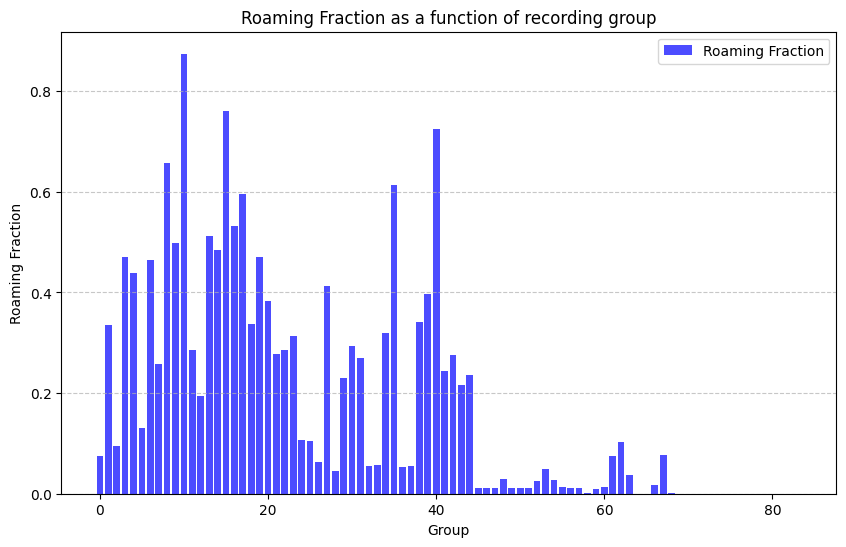

In [14]:
groups = y.index  # X-axis values (Group)
roaming_fractions = y['RoamingIndic']  # Y-axis values (Roaming Fraction)

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(groups, roaming_fractions, color='blue', alpha=0.7, label='Roaming Fraction')
plt.title("Roaming Fraction as a function of recording group")
plt.xlabel("Group")
plt.ylabel("Roaming Fraction")
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for y-axis
plt.legend()
plt.show()

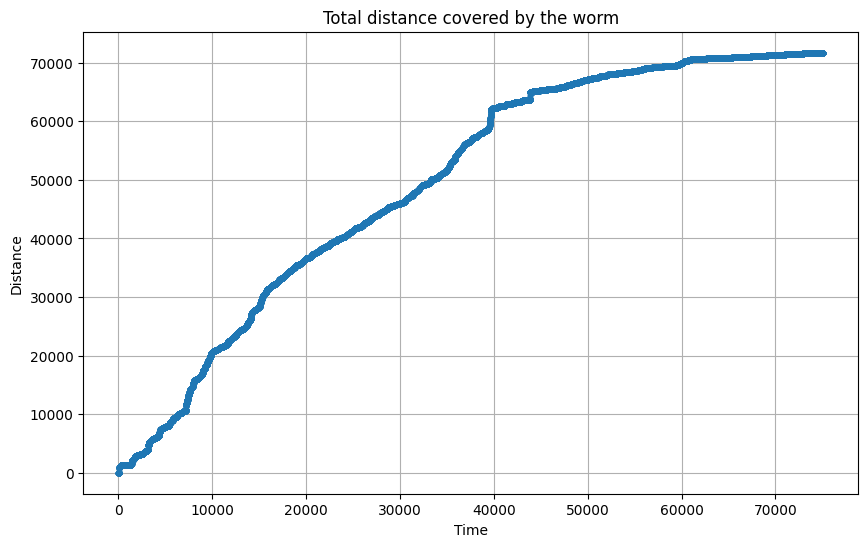

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Total Distance'], marker='.', linestyle='')
plt.title("Total distance covered by the worm")
plt.xlabel("Time")
plt.ylabel("Distance")
plt.grid(True)
plt.show()


Final statistics:

In [16]:
average_speed = data.EucSpeed.mean()
average_distance_per_frame = data['dist'].mean()
maximal_stpwsdistance_travalled = data['dist'].max()
maximal_distance_travalled = data['Total Distance'].max()
average_change_in_pixels = data['Change in Pixels'].mean()
average_angular_speed= data['Angular Change'].mean()
FRF = roaming_frac/total_time
final_age

396.005

In [17]:
grouped_speed = data.groupby('group').EucSpeed.mean()
grouped_distance = data.groupby('group').dist.mean()
grouped_max_distance = data.groupby('group')['Total Distance'].max()
grouped_avg_change_pixels = data.groupby('group')['Change in Pixels'].mean()
grouped_avg_change_speed = data.groupby('group')['Change in Speed'].mean()
grouped_avg_angular_speed = data.groupby('group')['Angular Change'].mean()
y = data.groupby(['group']).RoamingIndic.mean()

grouped_df = pd.concat(
    {'average_speed': grouped_speed,
        'average_distance_per_frame': grouped_distance,
        'maximal_distance_traveled': grouped_max_distance,
        'average_change_in_pixels': grouped_avg_change_pixels,
        'average_angular_speed': grouped_avg_angular_speed,
         'average_change_speed' : grouped_avg_change_speed,
         'roaming_fraction' : y
    },
    axis=1
).reset_index()

print(grouped_df)

    group  average_speed  average_distance_per_frame  \
0     0.0       0.746495                    1.492991   
1     1.0       0.789204                    1.578407   
2     2.0       0.287083                    0.574166   
3     3.0       1.203936                    2.407871   
4     4.0       0.962011                    1.924021   
..    ...            ...                         ...   
79   79.0       0.061198                    0.122397   
80   80.0       0.041579                    0.083159   
81   81.0       0.035228                    0.070456   
82   82.0       0.037243                    0.074486   
83   83.0       0.023919                    0.047838   

    maximal_distance_traveled  average_change_in_pixels  \
0                 1342.030292                  0.005562   
1                 2762.114428                  0.231368   
2                 3371.158219                 -0.222469   
3                 5618.137941                 -0.003337   
4                 7402.807252   

In [26]:
grouped_speed = data.groupby('group').EucSpeed.mean()
grouped_distance = data.groupby('group').dist.mean()
grouped_max_distance = data.groupby('group')['Total Distance'].max()
grouped_avg_change_pixels = data.groupby('group')['Change in Pixels'].mean()
grouped_avg_change_speed = data.groupby('group')['Change in Speed'].mean()
grouped_avg_angular_speed = data.groupby('group')['Angular Change'].mean()
fg = data.groupby('group')['Time elapsed (in hours)'].apply(lambda x: x.iloc[-1])
stdd = data.groupby('group')['EucSpeed'].std()
y = data.groupby(['group']).RoamingIndic.mean()

# Compute the difference between consecutive rows
difference = grouped_max_distance.diff()

# Combine the original values and the differences into a DataFrame
result_df = pd.DataFrame({
    'group': grouped_max_distance.index,
    'max_distance': grouped_max_distance.values,
    'difference': difference.values
})

result_df.difference[0]=result_df.max_distance[0]
result_df.set_index('group', inplace = True)
result_df.drop(columns = ['max_distance'])
print(result_df)


       max_distance   difference
group                           
0.0     1342.030292  1342.030292
1.0     2762.114428  1420.084136
2.0     3371.158219   609.043791
3.0     5618.137941  2246.979721
4.0     7402.807252  1784.669311
...             ...          ...
79.0   71474.100085   110.034689
80.0   71548.886797    74.786712
81.0   71612.338427    63.451630
82.0   71679.320872    66.982445
83.0   71721.991955    42.671082

[84 rows x 2 columns]


In [27]:
grouped_df = pd.concat(
    {'average_speed': grouped_speed,
        'average_distance_per_frame': grouped_distance,
        'maximal_distance_traveled': grouped_max_distance,
        'average_change_in_pixels': grouped_avg_change_pixels,
        'average_angular_speed': grouped_avg_angular_speed,
         'distance_travaled' : result_df,
         'average_change_speed' : grouped_avg_change_speed,
         'time_elapsed_(hours)' : fg,
         'std_speed' : stdd,
         'std/mean' : stdd/grouped_speed,
         'roaming_fraction' : y
    },
    axis=1
).reset_index()
grouped_df.columns = grouped_df.columns.get_level_values(0)
grouped_df['lifespan']=final_age
grouped_df

,group,average_speed,average_distance_per_frame,maximal_distance_traveled,average_change_in_pixels,average_angular_speed,distance_travaled,distance_travaled,average_change_speed,time_elapsed_(hours),std_speed,std/mean,roaming_fraction,lifespan
0,0.0,0.746495,1.492991,1342.030292,0.005562,1.464103,1342.030292,1342.030292,1.042925,0.500000,9.181108,12.298947,0.074527,396.005
1,1.0,0.789204,1.578407,2762.114428,0.231368,1.487337,2762.114428,1420.084136,0.765688,6.500000,3.328055,4.216979,0.334816,396.005
2,2.0,0.287083,0.574166,3371.158219,-0.222469,1.882325,3371.158219,609.043791,0.225896,12.500000,0.297746,1.037144,0.094549,396.005
3,3.0,1.203936,2.407871,5618.137941,-0.003337,1.511171,5618.137941,2246.979721,1.037856,18.500000,8.225294,6.832005,0.469410,396.005
4,4.0,0.962011,1.924021,7402.807252,0.015573,1.560971,7402.807252,1784.669311,0.663196,24.500000,1.819691,1.891550,0.438265,396.005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,79.0,0.061198,0.122397,71474.100085,-0.002225,1.781653,71474.100085,110.034689,0.063809,474.500000,0.092102,1.504982,0.000000,396.005
80,80.0,0.041579,0.083159,71548.886797,0.000000,1.473149,71548.886797,74.786712,0.046127,480.500000,0.071747,1.725546,0.000000,396.005
81,81.0,0.035228,0.070456,71612.338427,0.002225,1.453781,71612.338427,63.451630,0.036061,486.500000,0.056229,1.596130,0.000000,396.005
82,82.0,0.037243,0.074486,71679.320872,-0.002225,1.453410,71679.320872,66.982445,0.039484,492.500000,0.063633,1.708592,0.000000,396.005


In [21]:
stdd = data.groupby('group')['EucSpeed'].std()
print(stdd)

group
0.0     9.181108
1.0     3.328055
2.0     0.297746
3.0     8.225294
4.0     1.819691
          ...   
79.0    0.092102
80.0    0.071747
81.0    0.056229
82.0    0.063633
83.0    0.034894
Name: EucSpeed, Length: 84, dtype: float64


In [48]:
stdd/grouped_speed

group
0.0     12.298947
1.0      4.216979
2.0      1.037144
3.0      6.832005
4.0      1.891550
          ...    
79.0     1.504982
80.0     1.725546
81.0     1.596130
82.0     1.708592
83.0     1.458865
Name: EucSpeed, Length: 84, dtype: float64